# Regression Coefficients Nullspace Perspective
This notebook contains contains examples and visualizations of the nullspace perspective for regression in high dimensions. 
Corresponding paper: 

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
# TODO: 
# 1. In the case of standardization, something doesn't seem to be working with Scipy minimize. Check what that is and. 
# 2. Potentially switch to different cosntraint based on Xv.

# Scatter plot:
# Fix legend!
# 5. Scatter the differences in predictions on the lower half of the plot. 
    # background + alpha = 0.5
    # cpolor spine
    # sclae always double the max difference!
    # min range 10e-12. 


# Report XV L2 norm, not gamma. 


In [2]:
import sys
import os

abspath = r"./src/"
sys.path.append(os.path.abspath(abspath ))

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)
np.random.seed(42)

# Custom functions
from hd_data import HD_Data
from basis_function_data import PolynomBasis, construct_data, construct_y_data
from nullspace import Nullspace

from utils import optimise_pls_cv
from plotting_utils import plot_X

%load_ext autoreload
%autoreload 2

In [3]:
# Varibles to set. 
# Paths are OS dependent.

# Data path
data_path = './data/'

# If outlier should be removed.
remove_outlier = False

# Shall plots be saved?
save_plots = False

# Path to save plots
if remove_outlier:
    save_plot_path = './results/NullspaceNoOutlier/' 
else:
    save_plot_path = './results/Nullspace/' 
    # save_plot_path = './../Nullspace/Figures/' 

plt.style.use('./styles/plots.mplstyle')

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_data = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_data = False


In [4]:
# Create PLS Model objects. 
# You can also used RR or lasso or other models instead.

model_PLS1 = PLSRegression(n_components=1, tol=1e-7, scale=False)
model_PLS2 = PLSRegression(n_components=2, tol=1e-7, scale=False)
model_PLS3 = PLSRegression(n_components=3, tol=1e-7, scale=False)
model_PLS4 = PLSRegression(n_components=4, tol=1e-7, scale=False)
model_PLS5 = PLSRegression(n_components=5, tol=1e-7, scale=False)
model_PLS6 = PLSRegression(n_components=6, tol=1e-7, scale=False)

models = [model_PLS1, model_PLS2, model_PLS3, model_PLS4, model_PLS5, model_PLS6]
model_names = ['PLS 1 Comp.', 'PLS 2 Comp.', 'PLS 3 Comp.', 'PLS 4 Comp.', 'PLS 5 Comp.', 'PLS 6 Comp.']

### Example I: Parabolas

In [5]:
if not load_data:
    x_min = 1.0
    x_max = 3.0
    means = np.array([0, 0, 0.3])
    stdv = np.array([0, 0, 0.3])
    draws = 50
    x = np.linspace(x_min, x_max, 200)[:, None]

    # True feature is the mean
    mean_function = lambda a : np.mean(a)

    # Data without noise
    poly_basis = PolynomBasis(len(means), [x_min, x_max])
    poly_data = construct_data(poly_basis, mean_function, means, stdv, num_datapoints=200, draws=draws, plot_results=0)
    poly_hd_data = HD_Data(X=poly_data.X, x=x, y=poly_data.y)
    # Data with noise
    snr = 50
    poly_hd_data_noise = HD_Data(X=poly_data.X, x=x, y=poly_data.y).add_wgn(snr_x=snr, snr_y=snr)

    if save_data: 
        np.savetxt(
            data_path + "dml_parab.csv", np.hstack((poly_hd_data.X, np.expand_dims(poly_hd_data.y, axis=1))), delimiter=",", 
            header=f"Col. 0-49 X, col 50: x, col 51: y, poly. basis params.: means = {means}, stdv = {stdv}, y col. {draws}, sample mean, no noise \n x = {x.T}")
        np.savetxt(
            data_path + "dml_parab_n.csv", np.hstack((poly_hd_data_noise.X, np.expand_dims(poly_hd_data_noise.y, axis=1))), delimiter=",", 
            header=f"Col. 0-49 X, col 50: x, col 51: y, poly. basis params.: means = {means}, stdv = {stdv}, y col. {draws}, sample mean, added noise, snr = {snr} \n x = {x.T}")
else: 
    temp = np.loadtxt(data_path + "dml_parab.csv", skiprows=1, delimiter=",") 
    temp_n = np.loadtxt(data_path + "dml_parab_n.csv", skiprows=1, delimiter=",") 
    # Parameters from header ofcsv file
    x = np.linspace(1.0, 3.0, temp[:,:-1].shape[1])[:, None]

    dml_parab = HD_Data(X=temp[:,:-1], x=x, y=temp[:,-1]) 
    dml_parab_n = HD_Data(X=temp_n[:,:-1], x=x, y=temp_n[:,-1]) 

mean_reg_coef = (1/dml_parab.X.shape[1]) * np.ones(dml_parab.X.shape[1])

Constraint value: 0.000000000000, Method NRMSE
Constraint value: 9.894683091542071e-14, is too close to the numeric precision for trajectory analysis


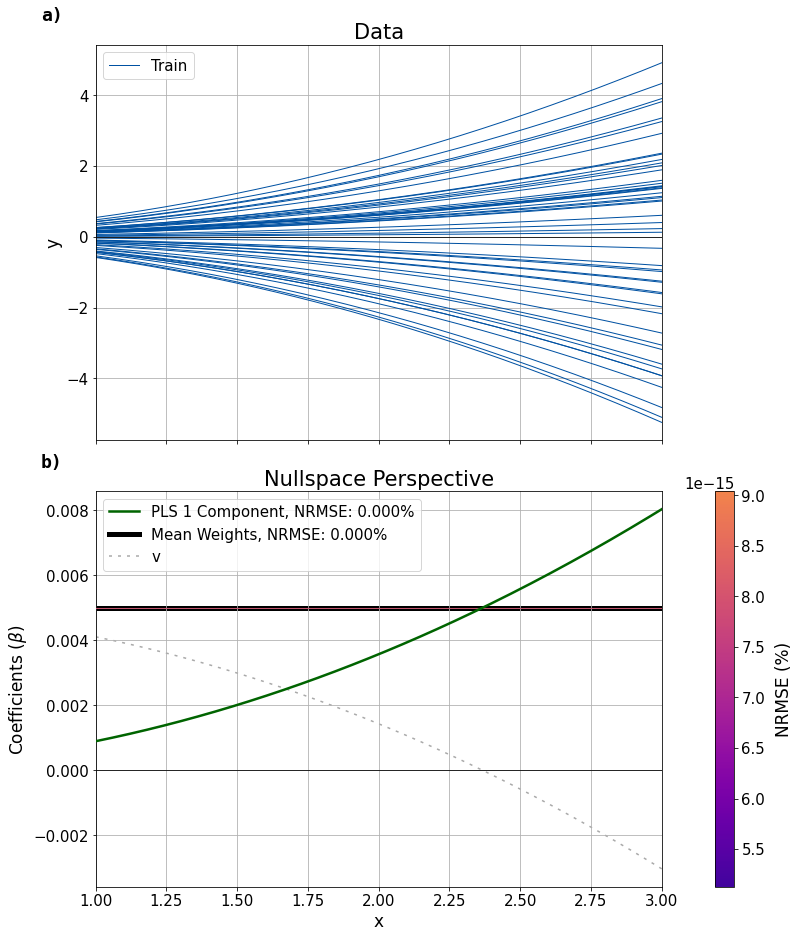

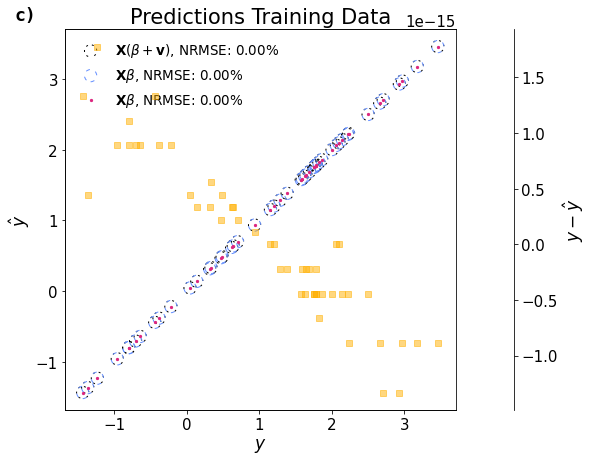

In [6]:
# Learn the weights (aka regression coefficients), using the models defined above.
# y cannot be used here, use z
nulls_parab = Nullspace(dml_parab)
nulls_parab = nulls_parab.learn_weights([model_PLS1], ['PLS 1 Comp.'])
nulls_parab.set_standardization(std=False)

nulls_parab.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, 
    w_beta_name='Mean Weights'
    )

nulls_parab, fig, ax = nulls_parab.nullspace_analysis(
    plot_results=True, 
    save_plot=save_plots, 
    path_save=save_plot_path, 
    file_name='Polynomial_example.pdf', 
    opt_gamma_method='NRMSE', 
    con_thres=10**(-13)
    )

nulls_parab.scatter_predictions(title="Predictions Training Data", ax_labelstr="c)")

NRMSE constraint threshold:  4.551812850670661e-05
Constraint value: 0.000045518128, Method NRMSE
Constraint value: 6.916900185212002e-14, is too close to the numeric precision for trajectory analysis


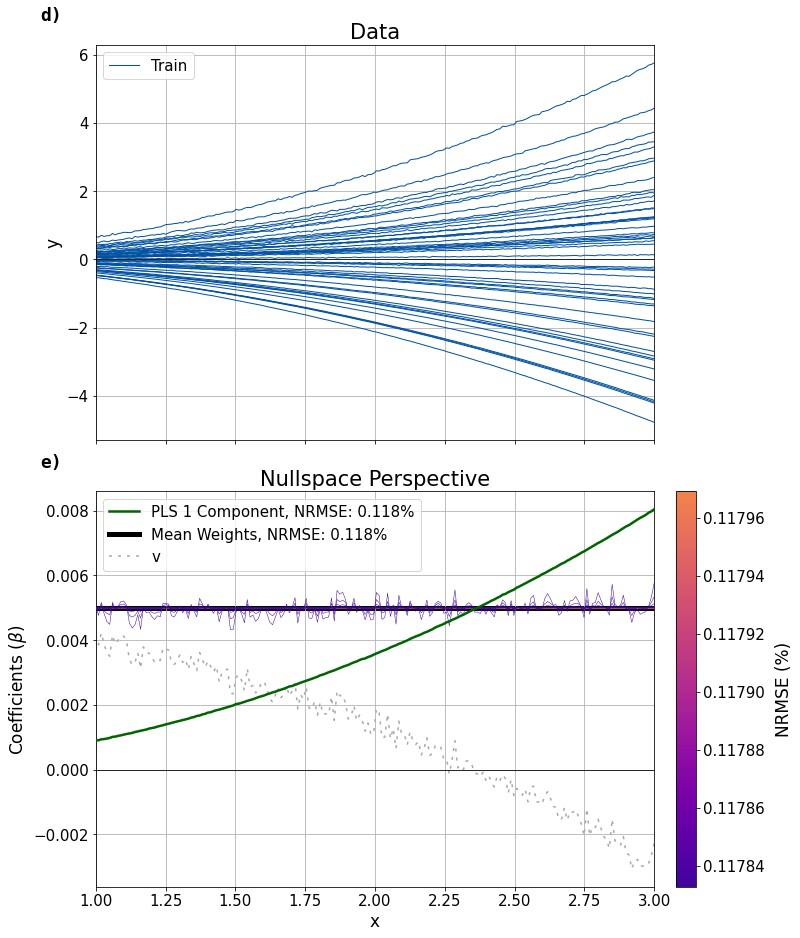

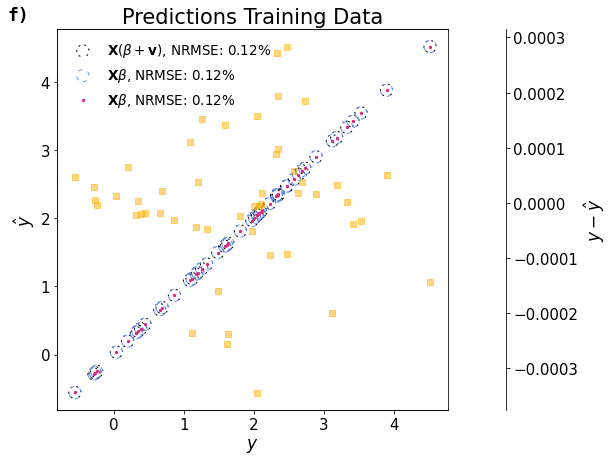

In [7]:
# TODO: Direclty with noise, remove the other one from the manuscript. 
# include one with the fused elastic net. 

nulls_parab_n = Nullspace(dml_parab_n)
nulls_parab_n = nulls_parab_n.learn_weights([model_PLS1], ['PLS 1 Comp.'])
nulls_parab_n.set_standardization(std=False)

nulls_parab_n.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, 
    w_beta_name='Mean Weights'
    )

nulls_parab_n, fig, ax = nulls_parab_n.nullspace_analysis(
    plot_results=True, 
    save_plot=save_plots, 
    path_save=save_plot_path, 
    file_name='Polynomial_example_noise.pdf', 
    opt_gamma_method='NRMSE', 
    con_thres=-0.5, 
    ax_labelstr = ("d)", "e)")
    )
nulls_parab_n.scatter_predictions(title="Predictions Training Data", ax_labelstr="f)")

# Example using LFP Data:

published with:
Data-driven prediction of battery cycle life before capacity degradation

https://www.nature.com/articles/s41560-019-0356-8

Source of data: 
https://data.matr.io/

License of LFP data: lfpdatalicense.txt

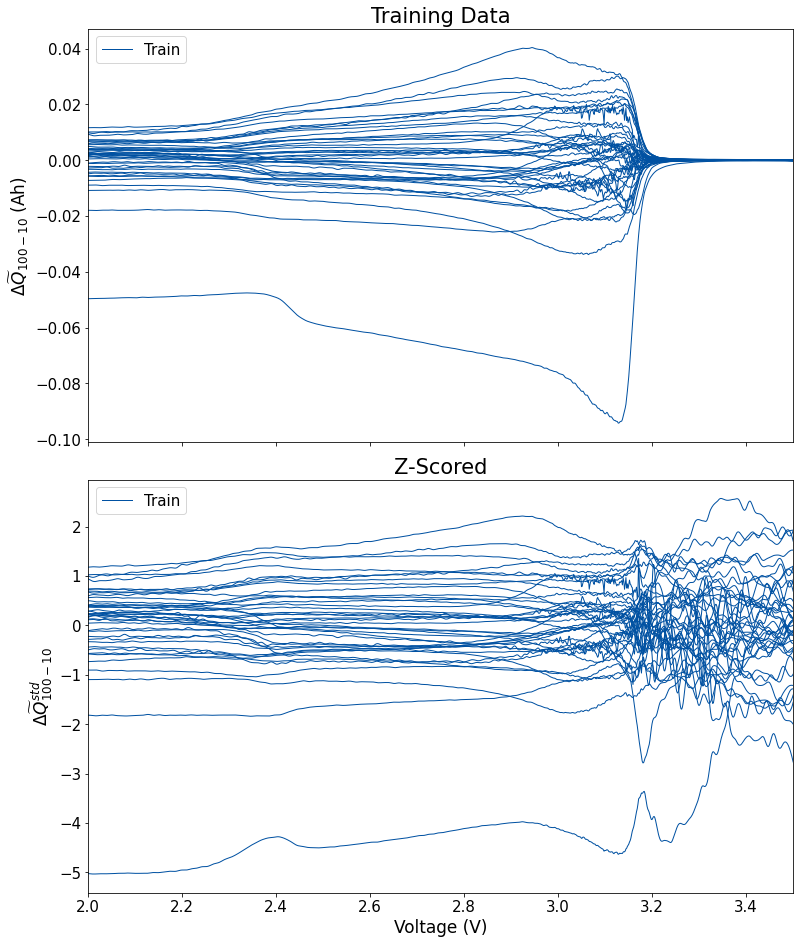

In [8]:
# Load the LFP Dataset
lfp_df = pd.read_csv(data_path + 'lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
# X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
# y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
# X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
# y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

fig, ax = plot_X(X_lfp_train, x_lfp)
if save_plots: 
    fig.savefig(save_plot_path + 'TrainingData.pdf') 

# Remove outlier 


In [9]:
if remove_outlier:
    id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
    X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
    y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

    fig, ax = plot_X(X_lfp_train, x_lfp, ax0_title='Training Data (outlier removed)', ax1_title='Z-Scored')
    if save_plots: 
        fig.savefig(save_plot_path + 'TrainingDataOutlierRemoved.pdf') 

y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

if not load_data: 
    y_lfp_train_mean_function = construct_y_data(X_lfp_train, mean_function, per_range=[0,1])
    data_lfp_mean = HD_Data(X=X_lfp_train, x=x_lfp, y=y_lfp_train_mean_function)
    data_lfp_mean = data_lfp_mean.add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_mean.csv', data_lfp_mean.y, delimiter=",", 
            header='Sample Mean reposne for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_mean.csv', skiprows=1, delimiter=',')
    if remove_outlier: 
        y = np.delete(y, id_outlier, axis=0)

    data_lfp_mean = HD_Data(X=X_lfp_train, x=x_lfp, y=y)

In [10]:
# LFP dataset synthethic y
nulls_lfp = Nullspace(data_lfp_mean)
nulls_lfp = nulls_lfp.learn_weights(models, model_names)
nulls_lfp.set_standardization(std=False)

{'rmse_vals': array([2.20219500e-07, 2.68426469e-08, 1.08407823e-08, 8.03511222e-09,
        7.93890872e-09, 1.08823227e-08, 1.62787852e-08, 1.65140416e-08,
        1.74363892e-08, 2.20624470e-08]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 2,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

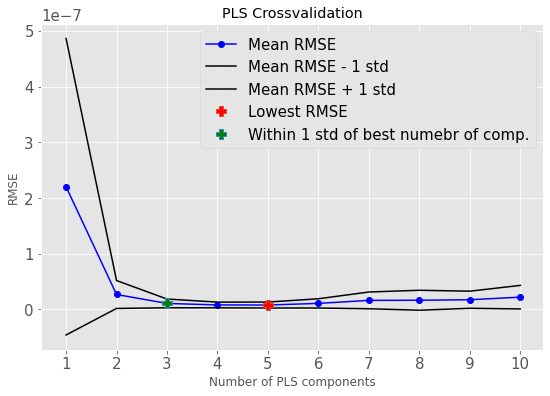

In [11]:
optimise_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=False)

{'rmse_vals': array([6.77048228e-07, 2.16754033e-07, 2.33415751e-08, 1.11521714e-08,
        6.88861331e-09, 9.69692807e-09, 1.36864727e-08, 1.96430159e-08,
        2.07993452e-08, 2.31247646e-08]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 3,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

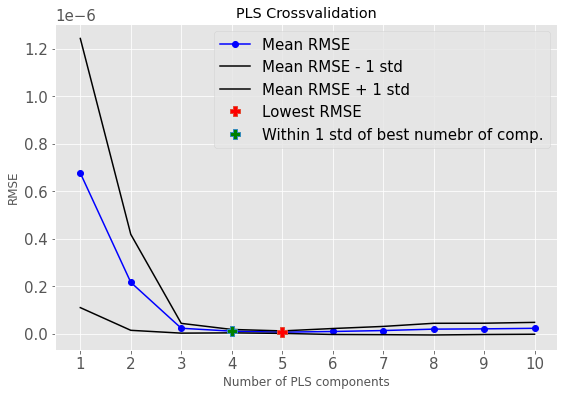

In [12]:
optimise_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=True)

In [13]:
if 0:
    nulls_lfp.set_standardization(std=True)
    nulls_lfp.set_nullspace_weights(
        key_alpha = 'PLS 1 Comp.', 
        w_alpha_name='PLS 1 Component', 
        w_beta = mean_reg_coef_lfp, 
        w_beta_name='Mean Weights'
        )
    nulls_lfp, nrmse, gamma_vals = nulls_lfp.nullspace_analysis(
        plot_results=False, save_plot=0, opt_gamma_method='NRMSE', con_thres=0)

NRMSE constraint threshold:  0.20559669339519143
Constraint value: 0.205596693402, Method NRMSE
Constraint value: -6.6319172375983726e-12, is too close to the numeric precision for trajectory analysis


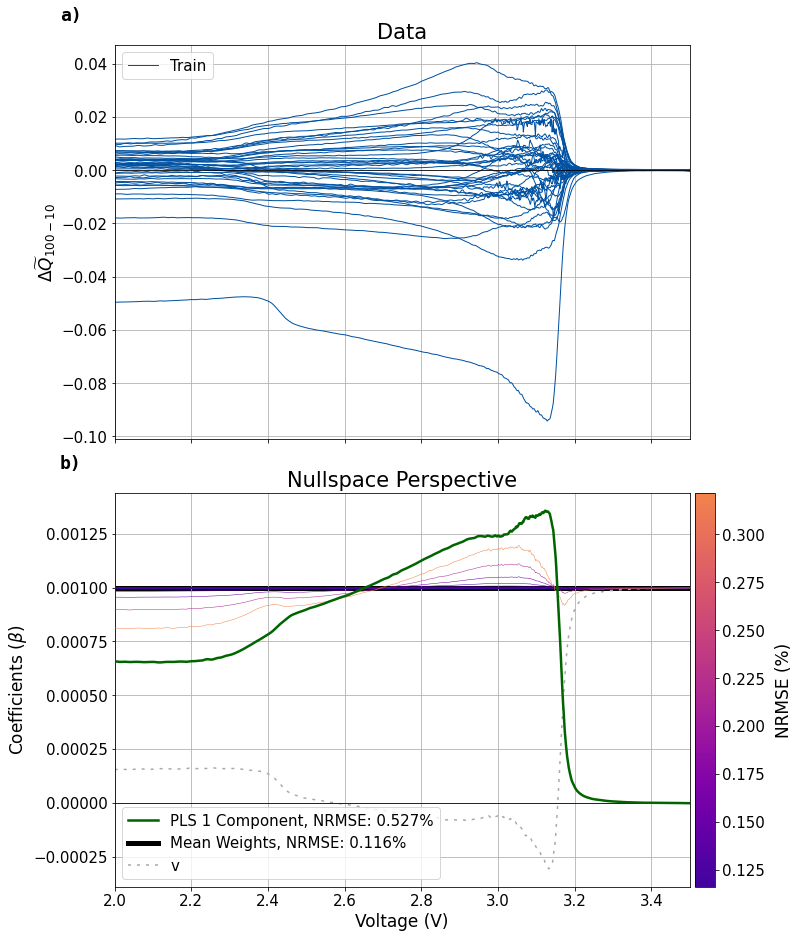

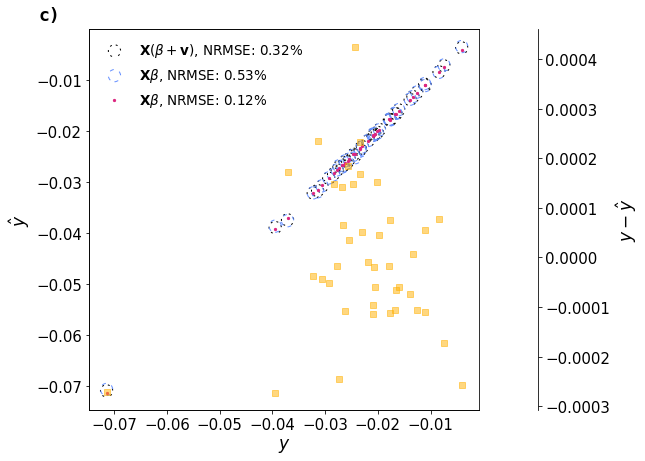

In [14]:
nulls_lfp.set_standardization(std=False)
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_PLS_mean.pdf') 

# Check how these predicitons get in there...
nulls_lfp.scatter_predictions()

Constraint value: 0.080000000000, Method NRMSE
Constraint value: 6.980527267330672e-15, is too close to the numeric precision for trajectory analysis


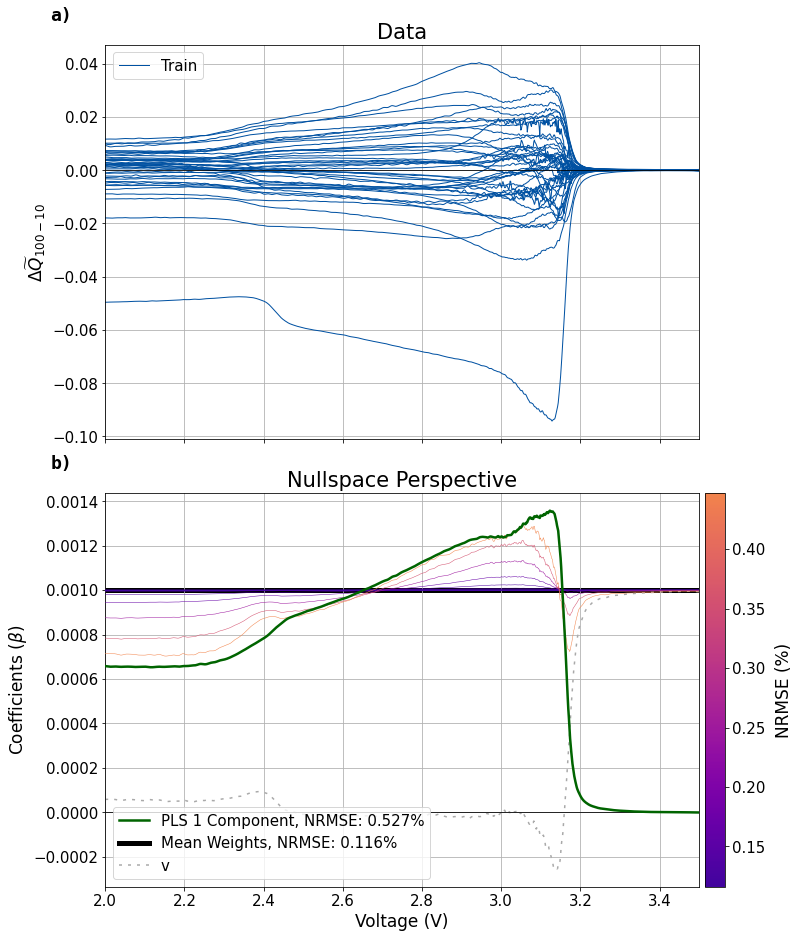

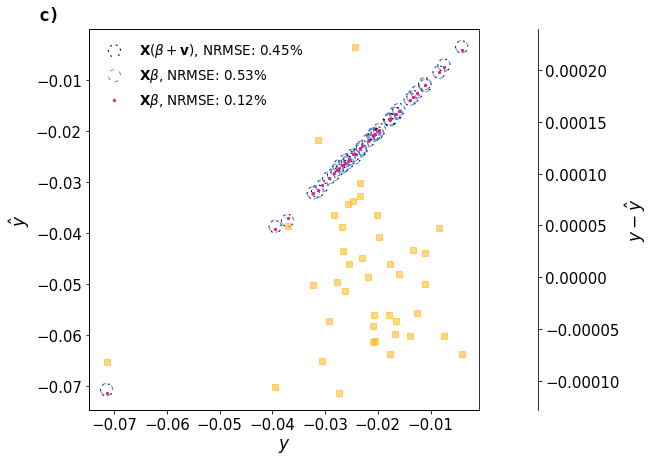

In [15]:
nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=0.08)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_PLS_mean_.pdf') 

nulls_lfp.scatter_predictions()

Constraint value: 0.010000000000, Method NRMSE
Constraint value: -6.609296443471635e-16, is too close to the numeric precision for trajectory analysis


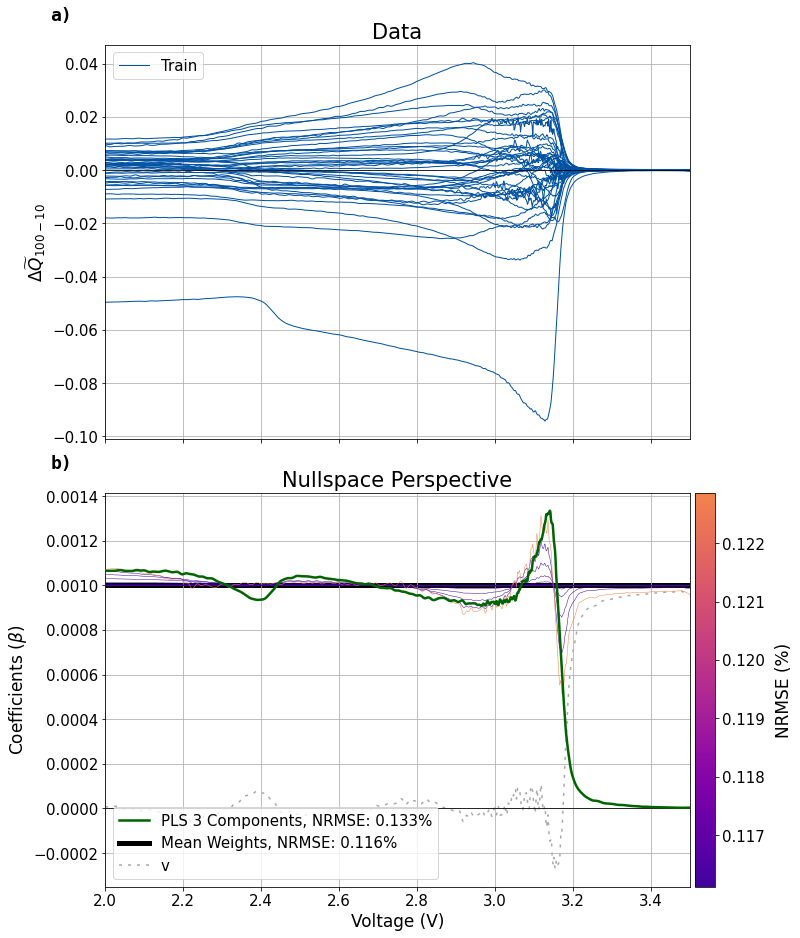

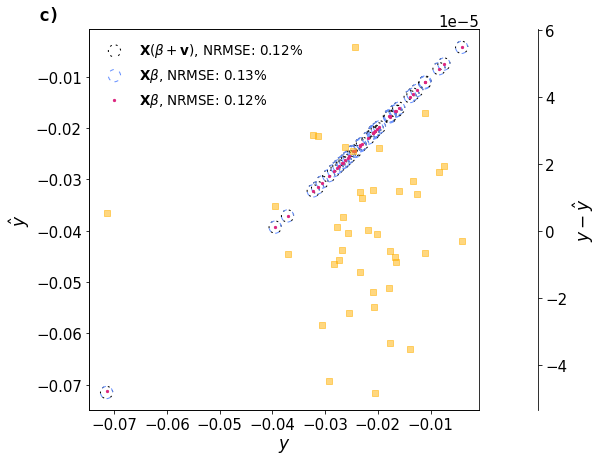

In [16]:
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 3 Comp.', 
    w_alpha_name='PLS 3 Components', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=0.01)


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_3PLS_mean.pdf')

nulls_lfp.scatter_predictions()

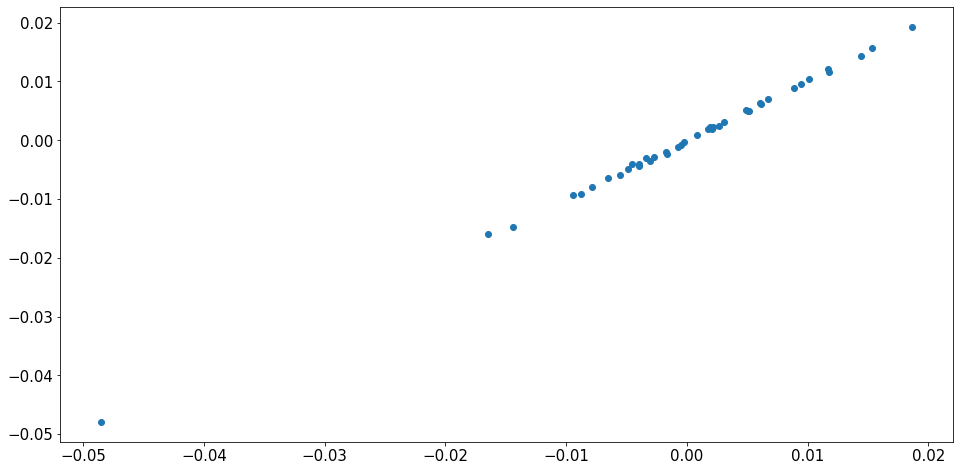

In [17]:
plt.scatter(nulls_lfp.X@mean_reg_coef_lfp, nulls_lfp.X@nulls_lfp.weights['PLS 1 Comp.']+nulls_lfp.X@nulls_lfp.nullsp['v_'][-1, :])

NRMSE constraint threshold:  0.009725416439438578
Constraint value: 0.972614197080, Method NRMSE
Constraint value: -0.9628887792117783, is too close to the numeric precision for trajectory analysis


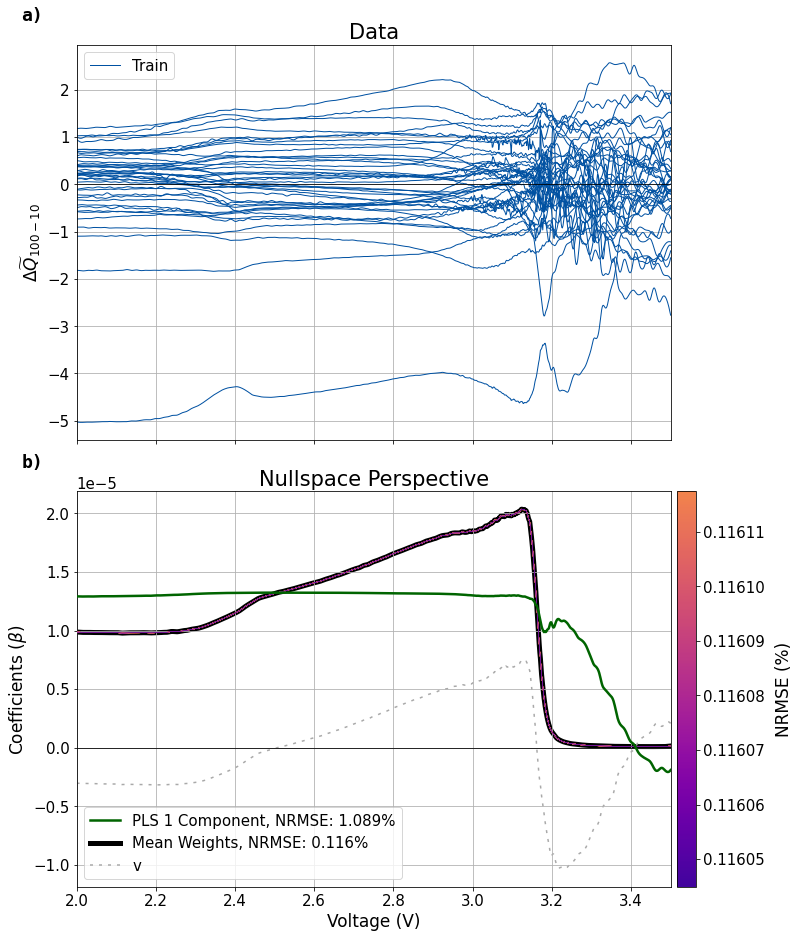

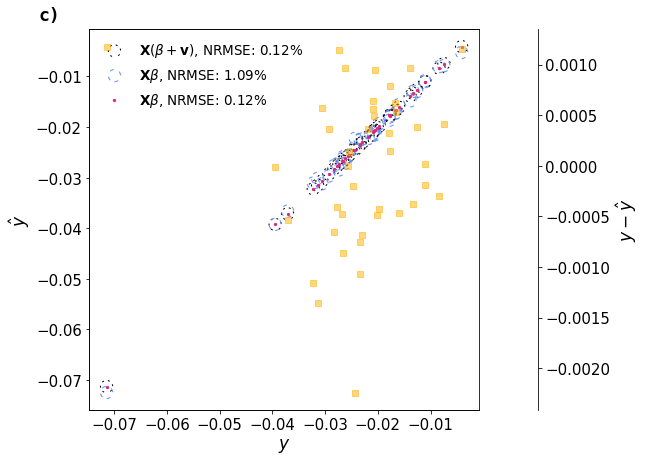

In [18]:
nulls_lfp.set_standardization(std=True)
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )
nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.01)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_1PLS_mean.pdf')

nulls_lfp.scatter_predictions()

NRMSE constraint threshold:  0.23504462641804486

Optimization took 13.79 seconds

Optimization depth: 29, max depth: 30

Gamma value corresponding to 2.4e-01 % is 0.0022146719233808324

Constraint value: 0.235

1.0000111207011153e-07

Scipy Optimization took 13.31 seconds

Constraint value: 0.235044725570, Method NRMSE


NRMSE constraint threshold:  0.23504462641804702
Constraint value: 0.470111248044, Method NRMSE
Constraint value: -0.23506662118740368, is too close to the numeric precision for trajectory analysis


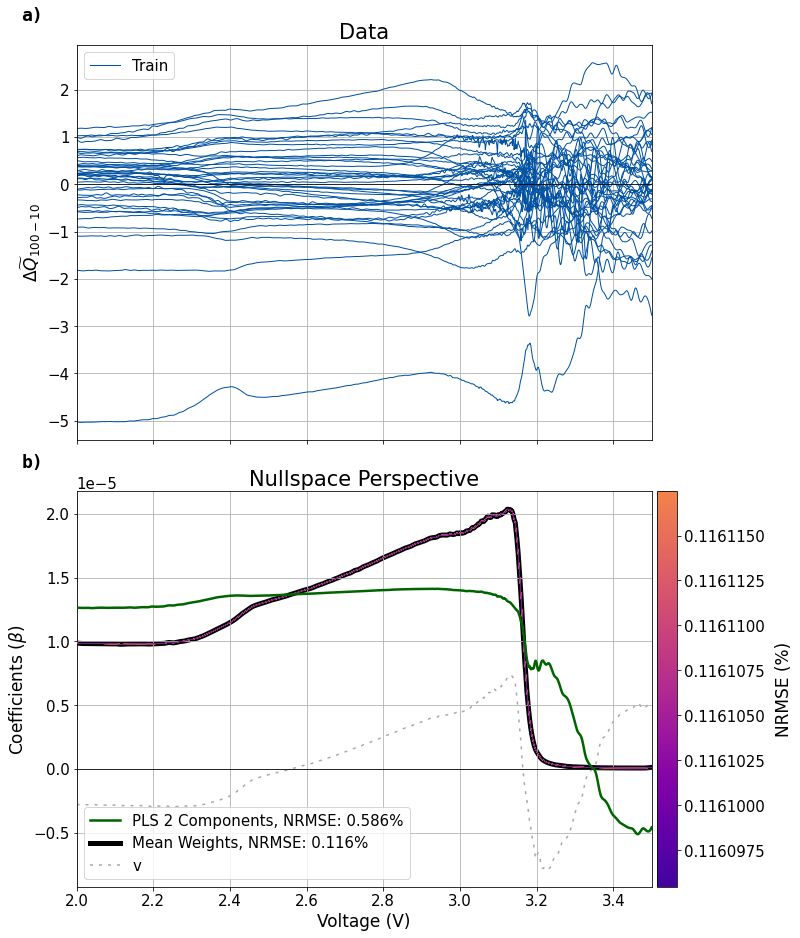

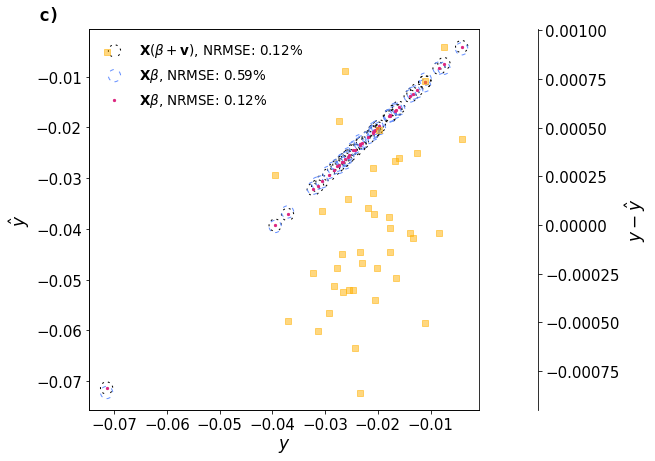

In [19]:
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 2 Comp.', 
    w_alpha_name='PLS 2 Components', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_3PLS_mean.pdf')

nulls_lfp.scatter_predictions()

Constraint value: 0.001201860587, Method NRMSE
Constraint value: -0.0007018603611386736, is too close to the numeric precision for trajectory analysis


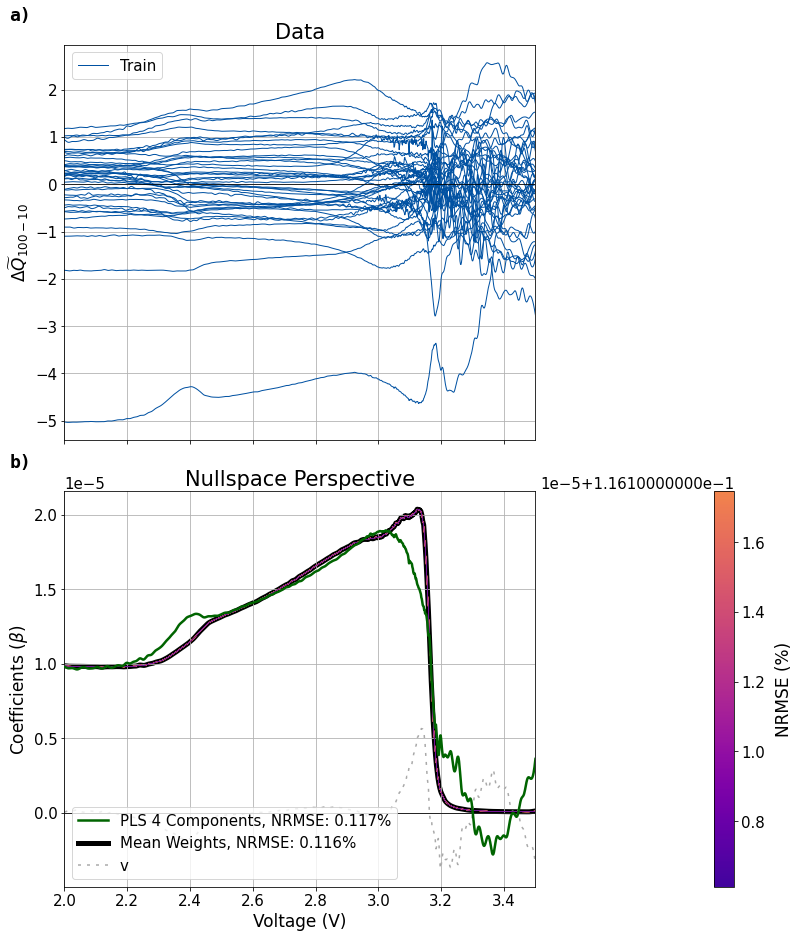

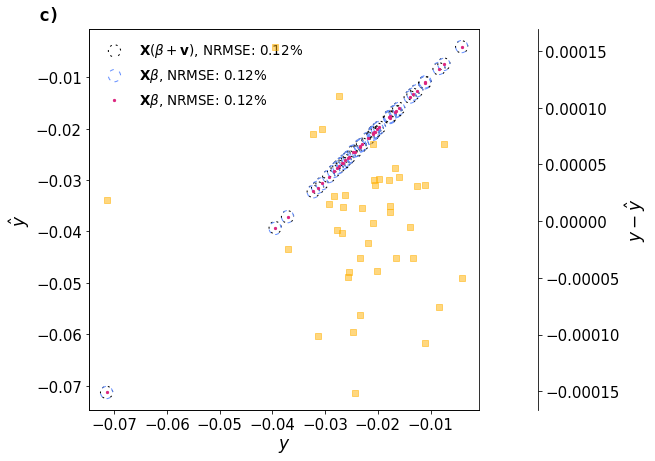

In [20]:
nulls_lfp.set_nullspace_weights(
    key_alpha = 'PLS 4 Comp.', 
    w_alpha_name='PLS 4 Components', 
    w_beta = mean_reg_coef_lfp, 
    w_beta_name='Mean Weights'
    )

nulls_lfp, fig, ax = nulls_lfp.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=0.0005)

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')   
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_4PLS_mean.pdf')


nulls_lfp.scatter_predictions()

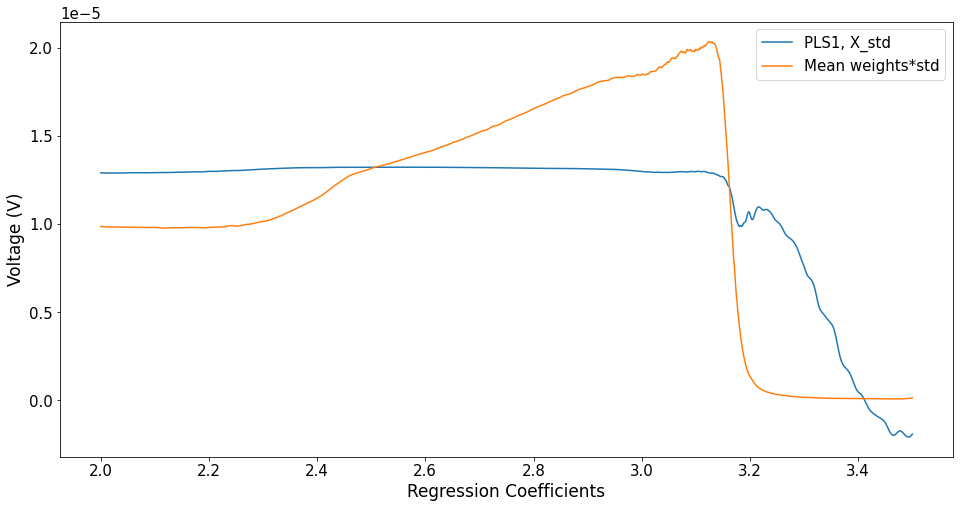

In [21]:
if 1:
    plt.plot(nulls_lfp.data.x, nulls_lfp.weights['PLS 1 Comp. std'], label='PLS1, X_std')
    plt.plot(nulls_lfp.data.x, mean_reg_coef_lfp*nulls_lfp.data.stdx, label='Mean weights*std')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Regression Coefficients')
    plt.legend()
    plt.show()

### Colum mean weights

In [22]:
# Contruct data object
# data LFP Synthethic YTrue repsonse is X@column_mean 

rcoef_lfp_cm =  np.mean(X_lfp_train, axis=0)

if not load_data: 
    y_lfps_train_cm = np.dot(X_lfp_train, rcoef_lfp_cm)

    dml_lfps_cm = HD_Data(X=X_lfp_train, x=x_lfp, y=y_lfps_train_cm)
    # Add noise to target values
    dml_lfps_cm = dml_lfps_cm.add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)
    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_cm.csv', dml_lfps_cm.y, delimiter=',', 
            header='Column Mean response for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_cm.csv', skiprows=1, delimiter=',')
    if remove_outlier: 
        y = np.delete(y, id_outlier, axis=0)
    dml_lfps_cm = HD_Data(X=X_lfp_train, x=x_lfp, y=y)

nulls_lfp_cm = Nullspace(dml_lfps_cm)
nulls_lfp_cm = nulls_lfp_cm.learn_weights(models, model_names)

{'rmse_vals': array([6.88552151e-05, 1.84344246e-05, 1.16838999e-05, 9.72247408e-06,
        8.96153878e-06, 1.17978373e-05, 1.13559374e-05, 9.72941342e-06,
        9.92059159e-06, 9.86862565e-06]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 2,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

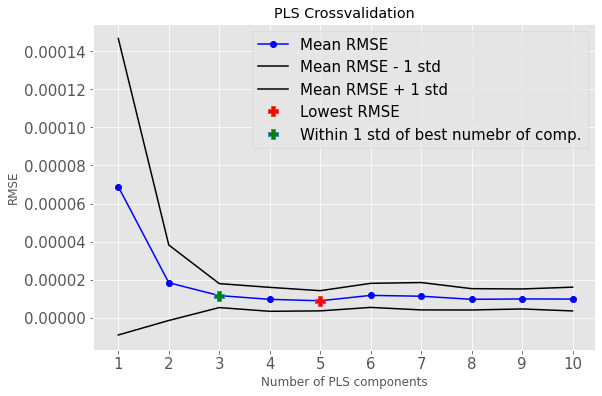

In [23]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=False)

{'rmse_vals': array([1.82973953e-03, 9.83120762e-04, 9.50104604e-05, 4.60664187e-05,
        1.89357005e-05, 1.25786015e-05, 1.20662301e-05, 1.63627021e-05,
        1.78372956e-05, 2.64740773e-05]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 5,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

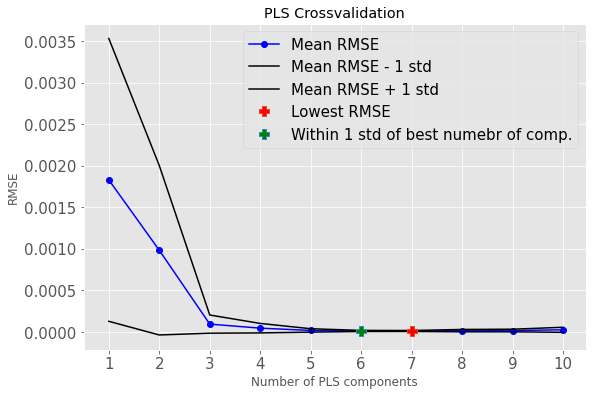

In [24]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=True)

NRMSE constraint threshold:  0.006720148590659385
Constraint value: 0.006720148591, Method NRMSE
Constraint value: -6.600622826091751e-16, is too close to the numeric precision for trajectory analysis


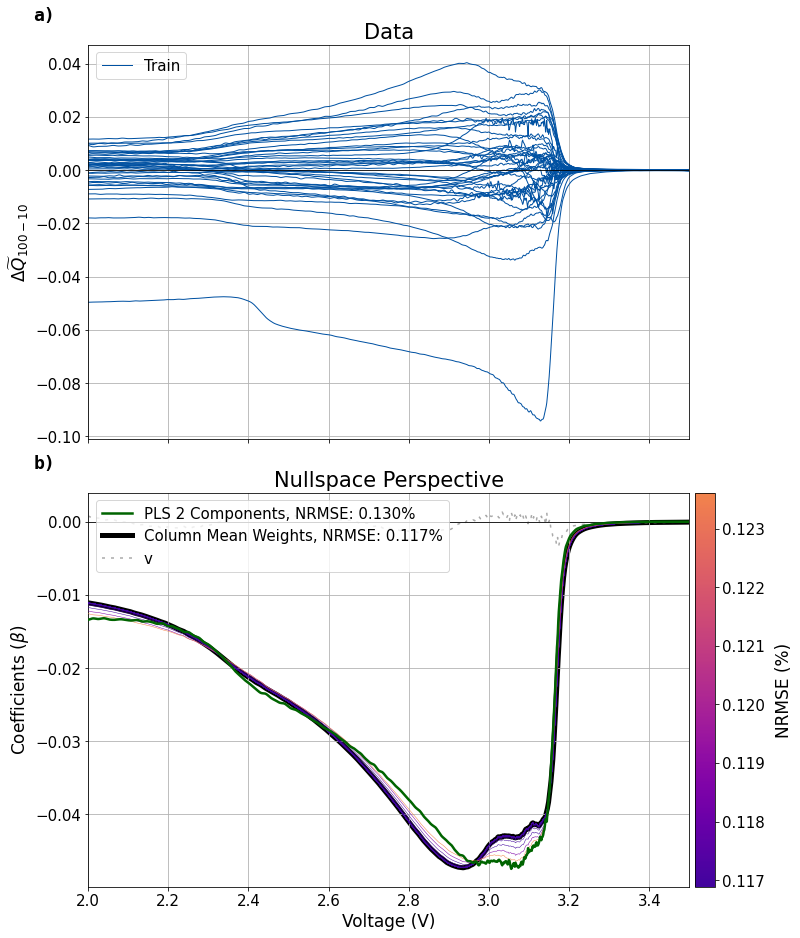

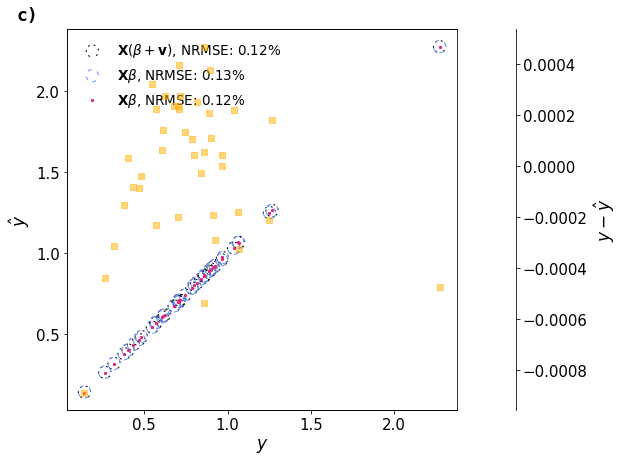

In [25]:
nulls_lfp_cm.set_standardization(std=False)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 2 Comp.', 
    w_alpha_name='PLS 2 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )
nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_2PLS_cm.pdf')


nulls_lfp_cm.scatter_predictions()

NRMSE constraint threshold:  0.000980973926790446
Constraint value: 0.000980973927, Method NRMSE
Constraint value: -5.2323596844150444e-15, is too close to the numeric precision for trajectory analysis


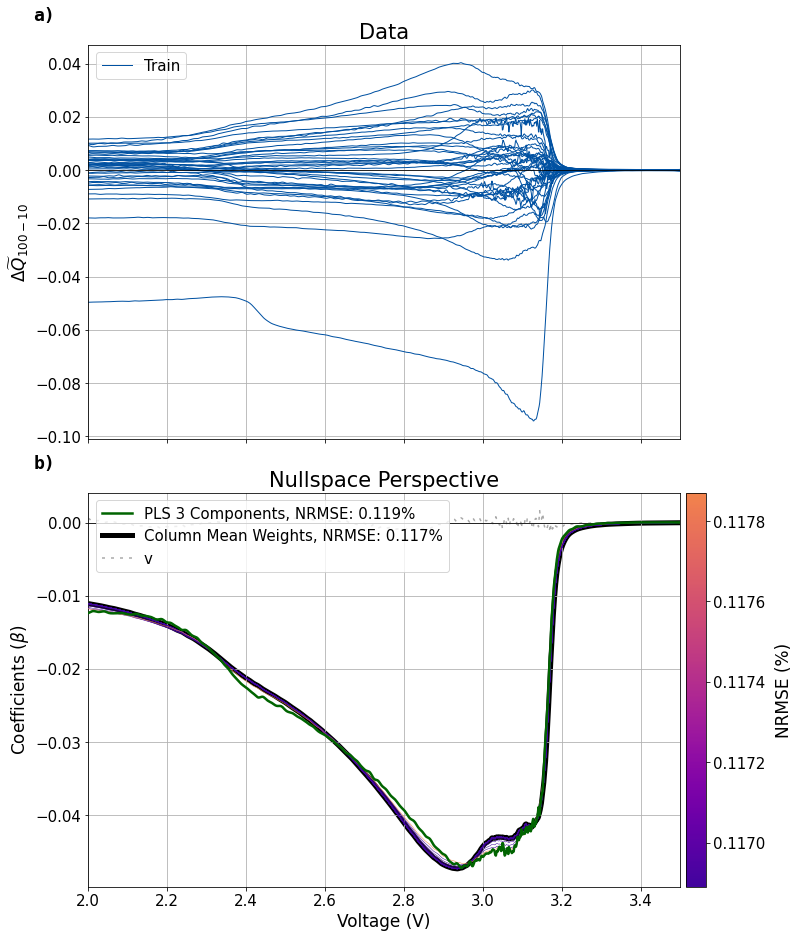

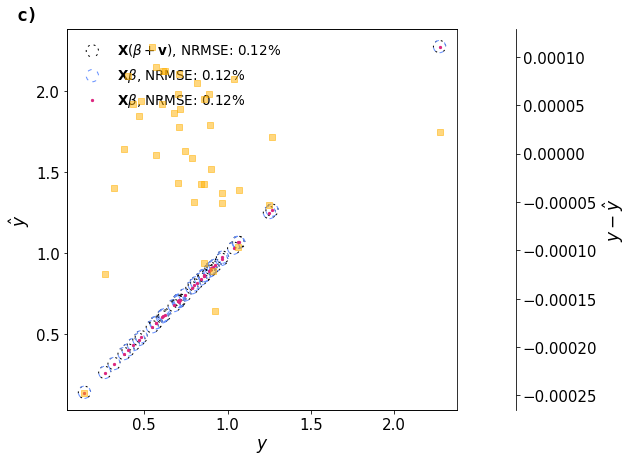

In [26]:
nulls_lfp_cm.set_standardization(std=False)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 3 Comp.', 
    w_alpha_name='PLS 3 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_3PLS_cm.pdf')


nulls_lfp_cm.scatter_predictions()

NRMSE constraint threshold:  0.0038448426033215813
Constraint value: 0.003844845627, Method NRMSE
Constraint value: -3.02749948027925e-09, is too close to the numeric precision for trajectory analysis


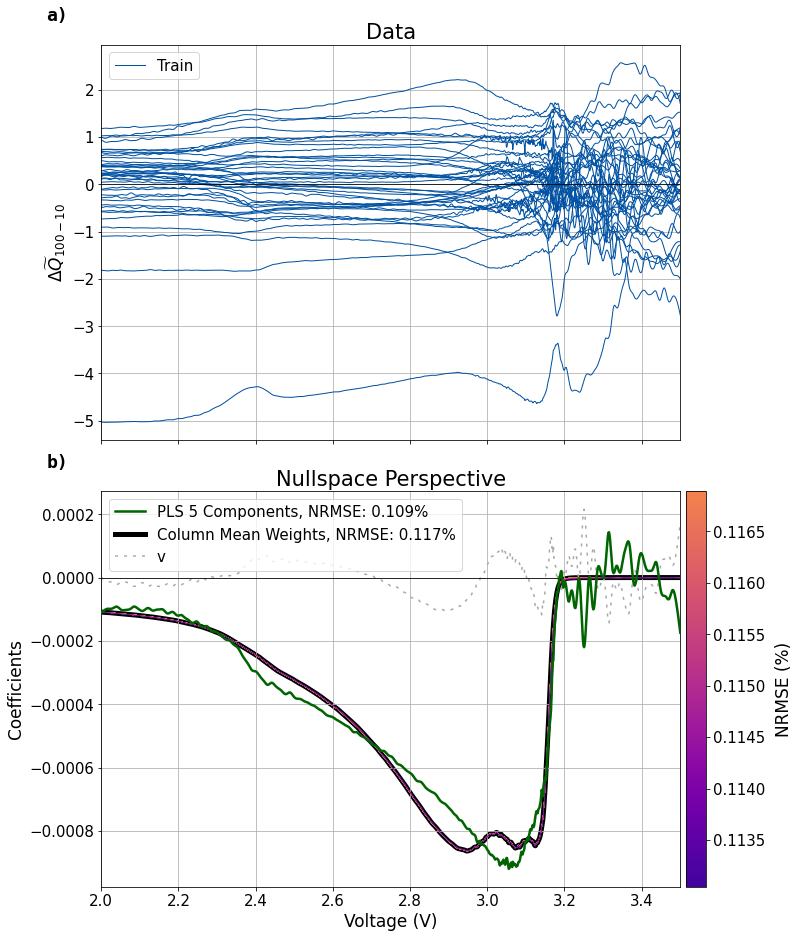

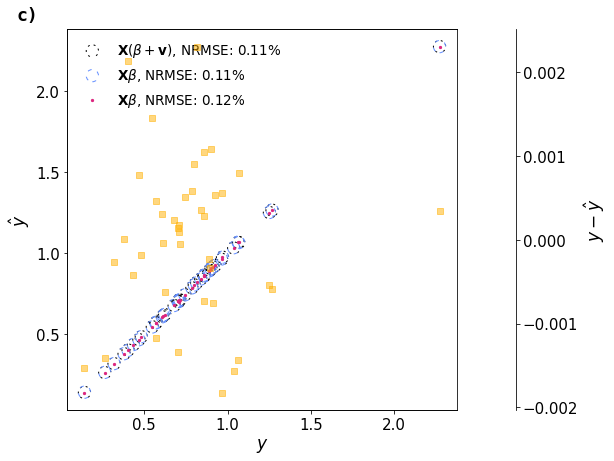

In [27]:
nulls_lfp_cm.set_standardization(std=True)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 5 Comp.', 
    w_alpha_name='PLS 5 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_5PLS_cm_std.pdf')


nulls_lfp_cm.scatter_predictions()

0.11304491904486132
0.11688975862412486
0.1092000734174817


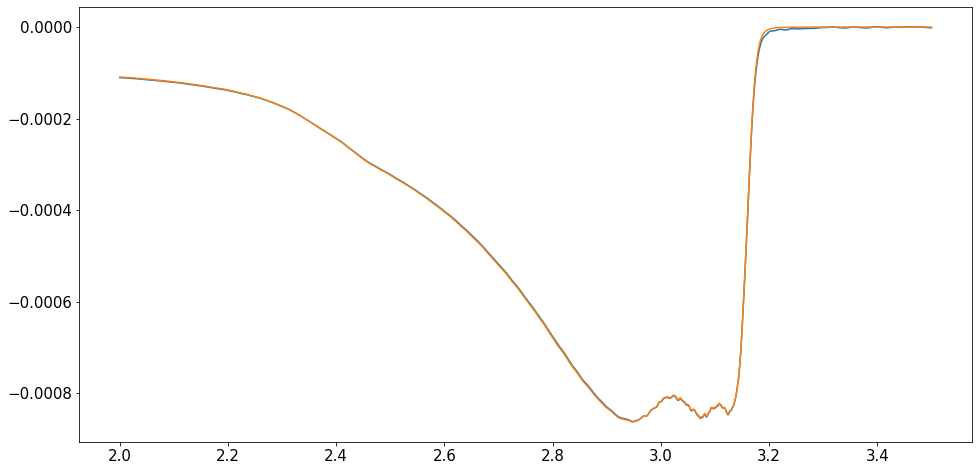

In [28]:
plt.plot(nulls_lfp_cm.data.x, nulls_lfp_cm.nullsp['w_alpha_std']+nulls_lfp_cm.nullsp['v_'][-1, :])
plt.plot(nulls_lfp_cm.data.x, nulls_lfp_cm.nullsp['w_beta_std'])

# calucleate NRMSE
from sklearn.metrics import mean_squared_error

print(100*mean_squared_error(nulls_lfp_cm.data.y_, nulls_lfp_cm.data.X_std@(nulls_lfp_cm.nullsp['w_alpha_std']+nulls_lfp_cm.nullsp['v_'][-1, :]), squared=False)/(np.max(y)-np.min(y)))
print(100*mean_squared_error(nulls_lfp_cm.data.y_, nulls_lfp_cm.data.X_std@(nulls_lfp_cm.nullsp['w_beta_std']), squared=False)/(np.max(y)-np.min(y)))
print(100*mean_squared_error(nulls_lfp_cm.data.y_, nulls_lfp_cm.data.X_std@(nulls_lfp_cm.nullsp['w_alpha_std']), squared=False)/(np.max(y)-np.min(y)))

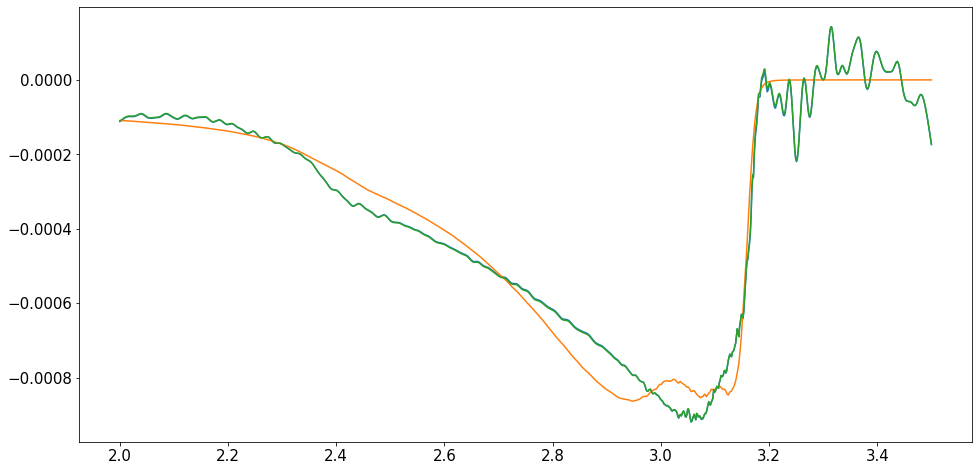

In [29]:
plt.plot(nulls_lfp_cm.data.x, nulls_lfp_cm.weights['PLS 5 Comp. std'], label='PLS5, X_std')
plt.plot(nulls_lfp_cm.data.x, rcoef_lfp_cm*nulls_lfp_cm.data.stdx, label='Column Mean weights*std')
plt.plot(nulls_lfp_cm.data.x, rcoef_lfp_cm*nulls_lfp_cm.data.stdx - nulls_lfp_cm.nullsp['v_'][-1, :].reshape(-1), label='Column Mean weights*std')
# plt.plot(nulls_lfp_cm.data.x, nulls_lfp_cm.nullsp['w_alpha'], label='')

NRMSE constraint threshold:  0.013932938483346487
Constraint value: 0.013932938618, Method NRMSE
Constraint value: -1.355601395025552e-10, is too close to the numeric precision for trajectory analysis


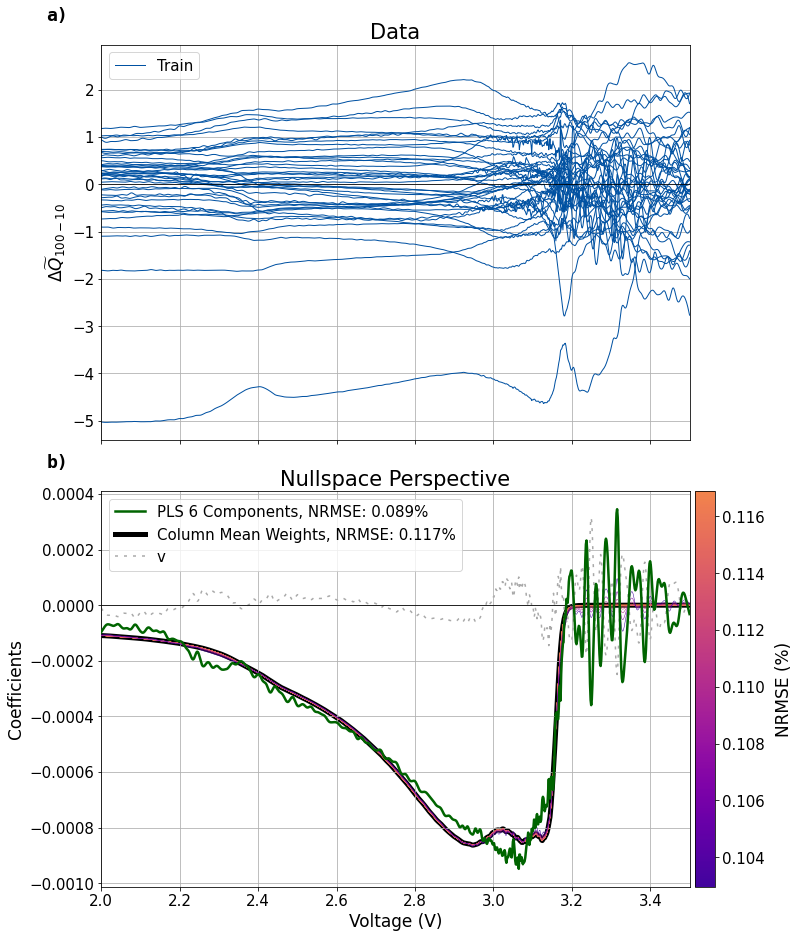

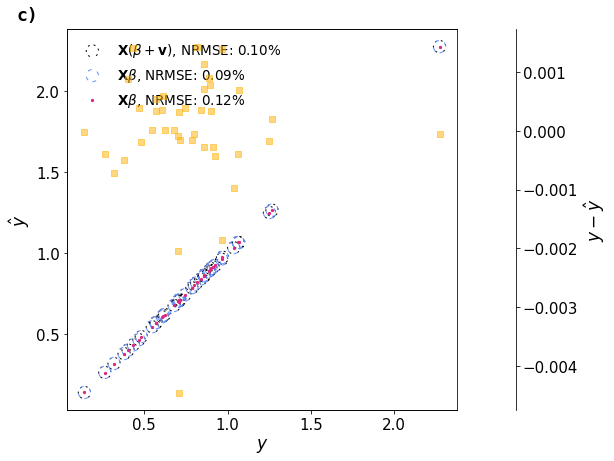

In [30]:
nulls_lfp_cm.set_standardization(std=True)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 6 Comp.', 
    w_alpha_name='PLS 6 Components', 
    w_beta = rcoef_lfp_cm, 
    w_beta_name='Column Mean Weights'
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0, opt_gamma_method='NRMSE', con_thres=-0.5)
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_6PLS_cm_std.pdf')


nulls_lfp_cm.scatter_predictions()

NRMSE constraint threshold:  0.027587218197026045
Constraint value: 0.027587218167, Method NRMSE
Constraint value: -2.0612539453068734e-12, is too close to the numeric precision for trajectory analysis


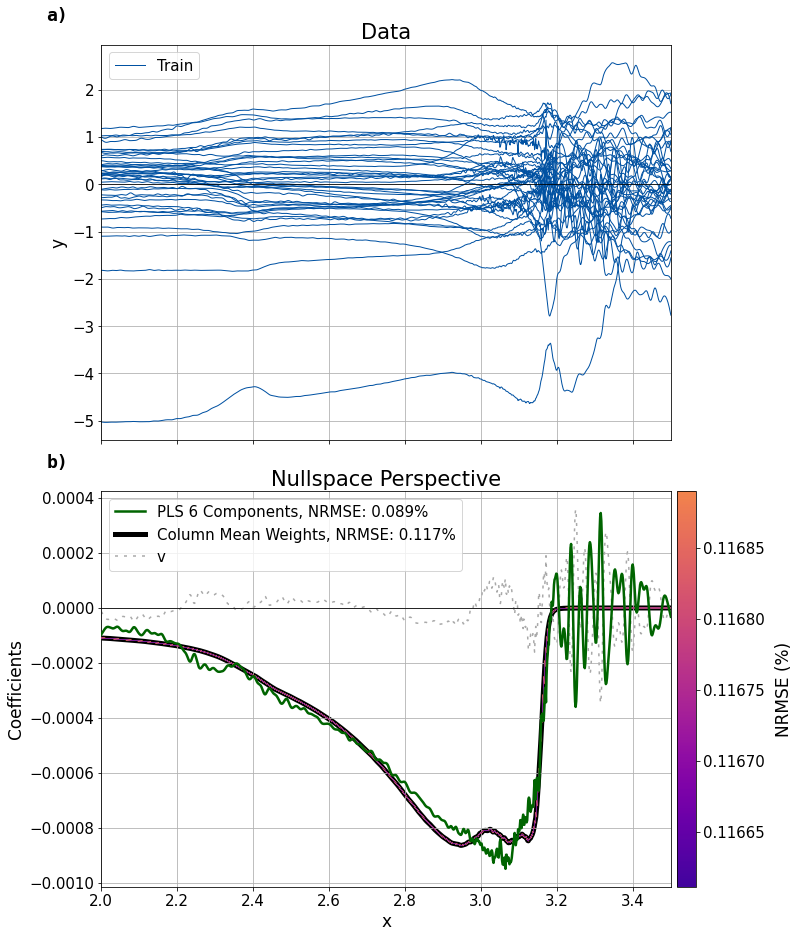

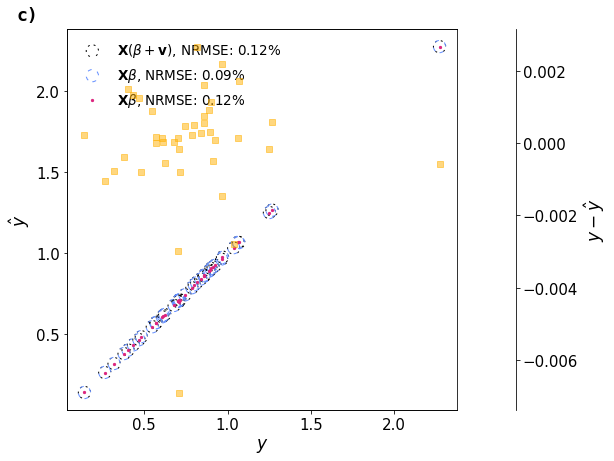

In [31]:
nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True, save_plot=0,  opt_gamma_method='NRMSE', con_thres=-0.99)

nulls_lfp_cm.scatter_predictions()